## Building The Environment
<sub>Uirá Caiado. Aug 19, 2016<sub>

### My Goal, For Now

Here I will build the environment where my agent will be trained. As it is a pretty complicated task, I created this notebook just to explore some options. Test an automated strategy is something pretty difficult, to tell the truth. There are some issues that I could talk about: historical prices are just one path from a stochastic process, the presence of the strategy on the market could change it etc.

However, would be interesting if the solution explored in my capstone could capture some aspect of the real structure of the markets. So, I will build an environment that will use historical data, but I will build it in a "agent-based model" fashion. Probably I will not do that to this project, but this structure can be useful for some future projects that I intend to do after completing this one.

I will use TAQ data from Bloomberg; It consists of 'level I' data from the PETR4 Brazilian Stock. I will explain about all these terms and data in my "official" project; here I just intend to share my experiments in a less formal way. Level I data is the information of the first queue of order book (bid and ask), and trades that have been made (TAQ is an acronym for Trade and Quote). It alone is not enough to create an order book, but I will try to do that. If I complete this task, I could exclude the historical data and include some random agents to build a Monte Carlo of the order book, for example. I will try to build it upon the codes for the SmartCab project. Instead of the gridlike world, my world will be discrete, but an order book.

### Exploring The Data

So, let's start looking at the data that I have available. It is data from the last 19 days from PETR4 stock from Brazilian BMFBovespa. I choose this share because it is on of the most active stocks in our market, but still the data produced is manageable (60 to 90 thousands of rows by day).

In [8]:
import zipfile
s_fname = "data/petr4_0725_0818.zip"
archive = zipfile.ZipFile(s_fname, 'r')
def foo():
    f_total = 0.
    for i, x in enumerate(archive.infolist()):
        f_total += x.file_size/ 1024.**2
        for num_rows, row in enumerate(archive.open(x)):
            pass
        print "{}:\t{:,.0f} rows\t{:0.2f} MB".format(x.filename, num_rows + 1, x.file_size/ 1024.**2)
    print '=' * 42
    print "TOTAL\t\t{} files\t{:0.2f} MB".format(i+1,f_total)

%time foo()

20160725.csv:	117,170 rows	4.66 MB
20160726.csv:	105,898 rows	4.20 MB
20160727.csv:	131,058 rows	5.22 MB
20160728.csv:	117,286 rows	4.65 MB
20160729.csv:	145,368 rows	5.79 MB
20160801.csv:	114,815 rows	4.57 MB
20160802.csv:	113,642 rows	4.51 MB
20160803.csv:	142,283 rows	5.69 MB
20160804.csv:	144,832 rows	5.78 MB
20160805.csv:	117,901 rows	4.70 MB
20160808.csv:	93,502 rows	3.70 MB
20160809.csv:	86,078 rows	3.41 MB
20160810.csv:	112,320 rows	4.46 MB
20160811.csv:	153,925 rows	6.16 MB
20160812.csv:	154,212 rows	6.17 MB
20160815.csv:	114,955 rows	4.57 MB
20160816.csv:	111,913 rows	4.45 MB
20160817.csv:	122,047 rows	4.86 MB
20160818.csv:	90,024 rows	3.56 MB
TOTAL		19 files	91.09 MB
CPU times: user 6.63 s, sys: 36 ms, total: 6.66 s
Wall time: 6.66 s


Ok, all files together have 91 MB. It is not too much actually. Maybe I could try to get more data later. Well, let's read one of them.

In [63]:
import pandas as pd
df = pd.read_csv(archive.open(x), index_col=0, parse_dates=['Date'])
df.head()

,Date,Type,Price,Size
0,2016-08-18 10:09:09,TRADE,12.80,1000
1,2016-08-18 10:09:09,BID,12.80,15900
2,2016-08-18 10:09:09,ASK,12.81,2900
3,2016-08-18 10:09:09,ASK,12.81,7900
4,2016-08-18 10:09:09,BID,12.80,20900


In [64]:
print "{:%m/%d/%Y}".format(df.Date[0])
print df.groupby('Type').count()['Date']

08/18/2016
Type
ASK      32843
BID      32116
TRADE    25064
Name: Date, dtype: int64


As it is a "Trade And quotes" file, I was already expecting that there was the same number os Bid and Ask rows in the file. Well... it wasn't a problem to read this file. Well, I will read this file row by row now and include the prices in a binomial tree (the structure I intend to use to keep the order book). Let's see how long it takes.

In [65]:
from bintrees import FastRBTree

In [77]:
def foo():
    for idx, row in df.iterrows():
        pass

print "time to iterate the rows:"
%time foo()

time to iterate the rows:
CPU times: user 9.15 s, sys: 114 ms, total: 9.27 s
Wall time: 9.22 s


In [78]:
def foo():
    bid_tree = FastRBTree()
    ask_tree = FastRBTree()
    for idx, row in df.iterrows():
        if row.Type == 'BID':
            bid_tree.insert(row['Price'], row['Size'])
        elif row.Type == 'ASK':
            ask_tree.insert(row['Price'], row['Size'])

print "time to insert everything in binary trees:"
%time foo()

time to insert everything in binary trees:
CPU times: user 15.6 s, sys: 317 ms, total: 15.9 s
Wall time: 15.8 s


It is not excelent, but it is ok for now. I will see how bad it will be when I include all the logic needed. Now, let's visualize the prices on that day

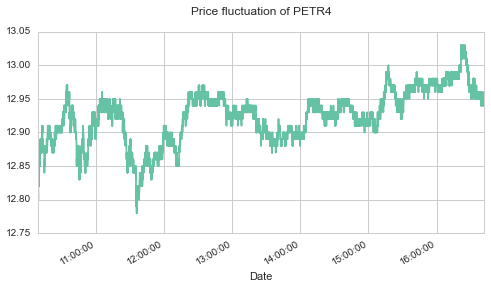

In [85]:
df_aux = df[df.Type == 'TRADE'].Price
df_aux.index = df[df.Type == 'TRADE'].Date
ax = df_aux.plot()
ax.set_title("Price fluctuation of PETR4\n");

Know what, let's visualize the prices of all days. I will plot the cumulated returns of this series

In [27]:
import pandas as pd

df_all = None

for i, x in enumerate(archive.infolist()):
    df = pd.read_csv(archive.open(x), index_col=0, parse_dates=['Date'])
    ts_date = df.Date[0].date()
    df.Date = ["{:%H:%M:%S}".format(x) for x in df.Date]
    df = df[df.Type == "TRADE"]
    df = pd.DataFrame(df.groupby('Date').last()['Price'])
    if i == 0:
        df_all = df.copy()
        df_all.columns = [ts_date] 
    else:
        df_aux = df.copy()
        df_aux.columns = [ts_date]
        df_all = df_all.join(df_aux)
df_all.index = pd.to_datetime(df_all.index)
df_all = df_all.fillna(method='ffill')
df_all = df_all.dropna()

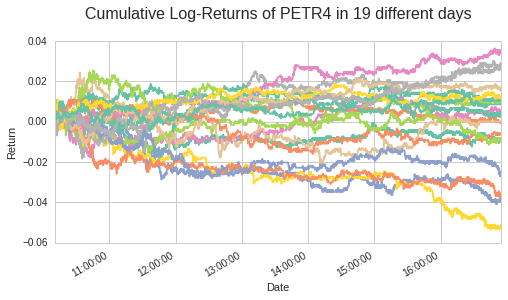

In [61]:
import numpy as np
df_logrtn = np.log(df_all/df_all.shift())
df_logrtn = df_logrtn[[(x.hour*60 + x.minute) < (16*60 + 55) for x in df_logrtn.index]]
ax = df_logrtn.cumsum().plot(legend=False)
ax.set_title('Cumulative Log-Returns of PETR4 in 19 different days\n', fontsize=16)
ax.set_ylabel('Return');

Interesting, isn't it?! It looks like the output of a Monte Carlo simulation. Well, the simulator that I will build should produce exactly this output.

### Pre-processing The Data

There is a problem using this data to do a simulation: the order of events. As there is just the first line of the order book, when happened a trade that filled more than an price level at once, I won't have the order in the second price level in my structure to be filled. So, I need to create it beforehand. To do so, I need to preprocess the dataset, so I can include this event. What I will do is sum up the trades that happend in sequence and include a new rows between the sequences to preper the dataset.


In [66]:
import zipfile
import csv
import numpy as np
import time
from collections import defaultdict


f_start = time.time()
s_fname = "data/petr4_0725_0818.zip"
archive = zipfile.ZipFile(s_fname, 'r')

f_total = 0.
f_bid = 0.
f_ask = 0.
for i, x in enumerate(archive.infolist()):
    s_fname = 'data/petr4_0725_0818_2/' + x.filename
    l_hold = []
    with open(s_fname, 'w') as fw:
        for idx, d_row in enumerate(csv.DictReader(archive.open(x))):
#             if idx == 61:
#                 raise NotImplementedError
            # check if should read row
            if int(d_row['Size'])%100 != 0:
                continue
            if float(d_row['Price']) == 0:
                continue
            # check if it is a trade
            if d_row[ 'Type'] == 'TRADE' and idx>0:
                l_hold.append(d_row.copy())
                continue
            if len(l_hold) == 1:
                d_aux = l_hold[0]
                l_aux = [d_aux[''], d_aux['Date'], d_aux[ 'Type'],
                         d_aux['Price'], d_aux['Size']]
                fw.write(','.join(l_aux) + '\n')
                l_hold = []
            elif len(l_hold) > 1:
                # hold info to use in msgs
                i_id = int(l_hold[0][''])
                s_time = l_hold[0]['Date']
                s_last = ''
                i_qty = 0
                # loop the list
                l_print = []
                for d_aux in l_hold:
                    if d_aux['Price'] != s_last:
                        if s_last != '':
                            # check if the price i a trade at bid or ask
                            if float(s_last) > f_ask:
                                s_msg = '{},{},ASK,{},{}\n'.format(i_id, s_time, s_last, i_qty)  
                                fw.write(s_msg)
                                i_id += 1
                            elif float(s_last) < f_bid:
                                s_msg = '{},{},BID,{},{}\n'.format(i_id, s_time, s_last, i_qty)  
                                fw.write(s_msg)
                                i_id += 1
                            # print the trade
                            for d_print in l_print:
                                
                                s_msg = '{},{},TRADE,{},{}\n'.format(i_id, s_time, d_print['Price'], d_print['Size'])  
                                fw.write(s_msg)
                                i_id += 1
                            l_print = []
                        # clean parameters
                        s_last = d_aux['Price']
                        i_qty = 0

                    i_qty += int(d_aux['Size'])
                    l_print.append(d_aux.copy())
                # print the last element
                if s_last != '':
                    if len(l_hold) > 1:
                        if float(s_last) > f_ask:
                            if float(s_last) == float(d_row['Price']):
                                s_msg = '{},{},ASK,{},{}\n'.format(i_id, s_time, s_last, int(d_row['Size']) + i_qty)  
                                fw.write(s_msg)
                                i_id += 1
                            else:
                                s_msg = '{},{},ASK,{},{}\n'.format(i_id, s_time, s_last, i_qty)  
                                fw.write(s_msg)
                                i_id += 1
                        elif float(s_last) < f_bid:
                            if float(s_last) == float(d_row['Price']):
                                s_msg = '{},{},BID,{},{}\n'.format(i_id, s_time, s_last, int(d_row['Size']) + i_qty)  
                                fw.write(s_msg)
                                i_id += 1
                            else:
                                s_msg = '{},{},BID,{},{}\n'.format(i_id, s_time, s_last, i_qty)  
                                fw.write(s_msg)
                                i_id += 1
                    # print the trade
                    for d_print in l_print:
                        s_msg = '{},{},TRADE,{},{}\n'.format(i_id, s_time, d_print['Price'], d_print['Size'])  
                        fw.write(s_msg)
                        i_id += 1
                    l_print = []
                # clean the list
                l_hold = []
            
            # print header
            if idx == 0:
                fw.write(',Date,Type,Price,Size\n')
            # follow the best bid and ask
            if d_row[ 'Type'] == 'BID':
                f_bid = float(d_row['Price'])
            elif d_row[ 'Type'] == 'ASK':
                f_ask = float(d_row['Price'])
            # print file
            l_aux = [d_row[''], d_row['Date'], d_row[ 'Type'],
                     d_row['Price'], d_row['Size']]
            fw.write(','.join(l_aux) + '\n')
#     break  # remove it

print "run in {:0.2f} seconds".format(time.time() - f_start)


run in 47.37 seconds


Now, let's check if I keep the same traded quantity in all files

In [28]:
import zipfile
import pandas as pd
s_fname = "data/petr4_0725_0818.zip"
archive = zipfile.ZipFile(s_fname, 'r')


f_total = 0.
i_same = 0
i_different = 0
for i, x in enumerate(archive.infolist()):
    s_fname = 'data/petr4_0725_0818_2/' + x.filename
    df = pd.read_csv(archive.open(x), index_col=0, parse_dates=['Date'])
    df2 = pd.read_csv(s_fname, index_col=0, parse_dates=['Date'])
    f_all = (df.ix[df.Type=='TRADE', 'Price'] * df.ix[df.Type=='TRADE', 'Size']).sum()
    f_all2 = (df2.ix[df2.Type=='TRADE', 'Price'] * df2.ix[df2.Type=='TRADE', 'Size']).sum()
    if f_all == f_all2:
        i_same += 1
    else:
        i_different += 1

print "{} files has the same number of trades".format(i_same)
print "{} files has DIFFERENT number of trades".format(i_different)
    

19 files has the same number of trades
0 files has DIFFERENT number of trades


Nice. I am going to use this files in the next steps.

### Building an Order book

I imagine a structure where my environment is an order book that operates in discrete time steps. At each time step, it allows randomly the agents (at each step) to take new actions. Then, the Environment updates the order book according to these messages.

At the beginning of each time step, all agent see the same state of the order book. Some of them will try to execute orders at the same price, for example, and the environment will accept just this kind of message while there are orders to be filled at that particular price. After that, It should distribute all the new states to the agents.

It also should keep the prices organized and, inside each price, should follow the orders arranged by "arrival time". Always that an agent grow his quantity of an existing order, it should be moved to the end of the queue on that price. The message that the agent should send to the environment should be something like that

```
{'instrumento_symbol': 'PETR4',
 'agent_id': 10,
 'order_entry_step': 15,
 'order_status': 'New'
 'last_order_id': 11,
 'order_id': 11,
 'order_side': 'BID',
 'agressor_indicator': 'Neutral',
 'order_price': 12.11,
 'total_qty_order': 100,
 'traded_qty_order': 0}
 ```
 
The limit order book will be ordered first by price and then by arrival. So, my first class should be the order itself. The second class should be the price level (that is a group of orders). The third one, the side of the book (a collection of Price Levels). Finally, the order book (the bid and ask side). So, now I need to create all the structure that handle these interations. If should receive an order and answer to the environment if it was acepted , the new ID, and, if there was a trade, the informations about the trade so the environment can update the state of the agents. I need a list of prices and another of orders. Oh... and a list of agents that have a list of their current orders on the market, but it is something handle by the environment. So, let's do that. First, let's implement the order structure.

In [13]:
# example of message
d_msg = {'instrumento_symbol': 'PETR4',
         'agent_id': 10,
         'order_entry_step': 15,
         'order_status': 'New',
         'last_order_id': 0,
         'order_id': 0,
         'order_side': 'BID',
         'order_price': 12.11,
         'total_qty_order': 100,
         'traded_qty_order': 0}

In [90]:
class Order(object):
    '''
    A representation of a single Order
    '''
    def __init__(self, d_msg):
        '''
        Instantiate a Order object. Save all parameter as attributes
        :param d_msg: dictionary.
        '''
        # keep data extract from file
        self.d_msg = d_msg.copy()
        self.d_msg['org_total_qty_order'] = self.d_msg['total_qty_order']
        f_q1 = self.d_msg['total_qty_order']
        f_q2 = self.d_msg['traded_qty_order']
        self.d_msg['total_qty_order'] = f_q1 - f_q2
        self.order_id = d_msg['order_id']
        self.last_order_id = d_msg['last_order_id']
        self.name = "{:07d}".format(d_msg['order_id'])
        self.main_id = self.order_id

    def __str__(self):
        '''
        Return the name of the Order
        '''
        return self.name

    def __repr__(self):
        '''
        Return the name of the Order
        '''
        return self.name

    def __eq__(self, other):
        '''
        Return if a Order has equal order_id from the other
        :param other: Order object. Order to be compared
        '''
        return self.order_id == other.order_id

    def __ne__(self, other):
        '''
        Return if a Order has different order_id from the other
        :param other: Order object. Order to be compared
        '''
        return not self.__eq__(other)

    def __hash__(self):
        '''
        Allow the Order object be used as a key in a hash table. It is used by
        dictionaries
        '''
        return self.order_id.__hash__()

    def __getitem__(self, s_key):
        '''
        Allow direct access to the inner dictionary of the object
        :param i_index: integer. index of the l_legs attribute list
        '''
        return self.d_msg[s_key]

In [91]:
my_order = Order(d_msg)
print "My id is {} and the price is {:0.2f}".format(my_order['order_id'], my_order['order_price'])
print "The string representation of the order is {}".format(my_order)

My id is 0 and the price is 12.11
The string representation of the order is 0000000


If the ID is zero, I will consider as the new order. Well... now I need to organize orders at the same price by arrival time and update its IDs. Also, if an existing order increases the quantity, should have been marked with a new ID. If the quantity decreases, it should keep the same place on the queue. So, the price level need to know what is the last general ID used by the Order Book:

In [94]:
from bintrees import FastRBTree

class PriceLevel(object):
    '''
    A representation of a Price level in the book
    '''
    def __init__(self, f_price):
        '''
        A representation of a PriceLevel object
        '''
        self.f_price = f_price
        self.i_qty = 0
        self.order_tree = FastRBTree()

    def add(self, order_aux):
        '''
        Insert the information in the tree using the info in order_aux. Return
        is should delete the Price level or not
        :param order_aux: Order Object. The Order message to be updated
        '''
        # check if the order_aux price is the same of the self
        if order_aux['order_price'] != self.f_price:
            raise DifferentPriceException
        elif order_aux['order_status'] == 'limit':
            self.order_tree.insert(order_aux.main_id, order_aux)
            self.i_qty += int(order_aux['total_qty_order'])
        # check if there is no object in the updated tree (should be deleted)
        return self.order_tree.count == 0

    def delete(self, i_last_id, i_old_qty):
        '''
        Delete the information in the tree using the info in order_aux. Return
        is should delete the Price level or not
        :param i_last_id: Integer. The previous secondary order id
        :param i_old_qty: Integer. The previous order qty
        '''
        # check if the order_aux price is the same of the self
        try:
            self.order_tree.remove(i_last_id)
            self.i_qty -= i_old_qty
        except KeyError:
            raise DifferentPriceException
        # check if there is no object in the updated tree (should be deleted)
        return self.order_tree.count == 0

    def __str__(self):
        '''
        Return the name of the PriceLevel
        '''
        return '{:,.0f}'.format(self.i_qty)

    def __repr__(self):
        '''
        Return the name of the PriceLevel
        '''
        return '{:,.0f}'.format(self.i_qty)

    def __eq__(self, other):
        '''
        Return if a PriceLevel has equal price from the other
        :param other: PriceLevel object. PriceLevel to be compared
        '''
        # just to make sure that there is no floating point discrepance
        f_aux = other
        if not isinstance(other, float):
            f_aux = other.f_price
        return abs(self.f_price - f_aux) < 1e-4

    def __gt__(self, other):
        '''
        Return if a PriceLevel has a gerater price from the other.
        Bintrees uses that to compare nodes
        :param other: PriceLevel object. PriceLevel to be compared
        '''
        # just to make sure that there is no floating point discrepance
        f_aux = other
        if not isinstance(other, float):
            f_aux = other.f_price
        return (f_aux - self.f_price) > 1e-4

    def __lt__(self, other):
        '''
        Return if a Order has smaller order_id from the other. Bintrees uses
        that to compare nodes
        :param other: Order object. Order to be compared
        '''
        f_aux = other
        if not isinstance(other, float):
            f_aux = other.f_price
        return (f_aux - self.f_price) < -1e-4

    def __ne__(self, other):
        '''
        Return if a Order has different order_id from the other
        :param other: Order object. Order to be compared
        '''
        return not self.__eq__(other)


In [ ]:
my_order = Order(d_msg)

In [97]:
# create different orders at the same price
d_msg1 = d_msg.copy()
d_msg1['order_id'] = 1
order1 = Order(d_msg1)
d_msg2 = d_msg.copy()
d_msg2['order_id'] = 2
order2 = Order(d_msg2)
d_msg3 = d_msg.copy()
d_msg3['order_id'] = 3
order3 = Order(d_msg3)

In [111]:
my_price = PriceLevel(d_msg['order_price'])
my_price.add(order1)
my_price.add(order2)
my_price.add(order3)

False

In [112]:
print "There is {} shares at {:.2f}".format(my_price, my_price.f_price)
print 'the orders in the book are: {}'.format(dict(my_price.order_tree))

There is 300 shares at 12.11
the orders in the book are: {1: 0000001, 2: 0000002, 3: 0000003}


Ok. Now, let's delete two of them

In [113]:
my_price.delete(1, 100)
my_price.delete(2, 100)
print "There is {} shares at {:.2f}".format(my_price, my_price.f_price)
print 'the orders in the book are: {}'.format(dict(my_price.order_tree))

There is 100 shares at 12.11
the orders in the book are: {3: 0000003}


I will let to the Environment handle the IDs, so the order book just need to keep the data ordered. Now, I am going to implement the Book side (a collection of Price levels) and the Limit Order Book (a collection of BookSide). You can see the final implementation on the file `book.py`.

In [22]:
import qtrader.book as book; reload(book);

In [23]:
my_book = book.LimitOrderBook('PETR4')

In [5]:
d_msg0 = {'agent_id': 10,
          'instrumento_symbol': 'PETR4',
          'last_order_id': 0,
          'order_entry_step': 15,
          'order_id': 0,
          'order_price': 12.12,
          'order_side': 'ASK',
          'order_status': 'New',
          'total_qty_order': 400,
          'traded_qty_order': 0,
          'agressor_indicator': 'Neutral'}


d_msg1 = {'agent_id': 10,
          'instrumento_symbol': 'PETR4',
          'last_order_id': 0,
          'order_entry_step': 15,
          'order_id': 1,
          'order_price': 12.11,
          'order_side': 'BID',
          'order_status': 'New',
          'total_qty_order': 100,
          'traded_qty_order': 0,
          'agressor_indicator': 'Neutral'}

d_msg2 = {'agent_id': 10,
          'instrumento_symbol': 'PETR4',
          'last_order_id': 0,
          'order_entry_step': 15,
          'order_id': 2,
          'order_price': 12.11,
          'order_side': 'BID',
          'order_status': 'New',
          'total_qty_order': 100,
          'traded_qty_order': 0,
          'agressor_indicator': 'Neutral'}

d_msg3 = {'agent_id': 10,
          'instrumento_symbol': 'PETR4',
          'last_order_id': 0,
          'order_entry_step': 15,
          'order_id': 3,
          'order_price': 12.10,
          'order_side': 'BID',
          'order_status': 'New',
          'total_qty_order': 200,
          'traded_qty_order': 0,
          'agressor_indicator': 'Neutral'}

d_msg4 = {'agent_id': 10,
          'instrumento_symbol': 'PETR4',
          'last_order_id': 0,
          'order_entry_step': 15,
          'order_id': 4,
          'order_price': 12.10,
          'order_side': 'BID',
          'order_status': 'New',
          'total_qty_order': 100,
          'traded_qty_order': 0,
          'agressor_indicator': 'Neutral'}

d_msg5 = {'agent_id': 10,
          'instrumento_symbol': 'PETR4',
          'last_order_id': 0,
          'order_entry_step': 15,
          'order_id': 3,
          'order_price': 12.10,
          'order_side': 'BID',
          'order_status': 'Replaced',
          'total_qty_order': 100,
          'traded_qty_order': 0,
          'agressor_indicator': 'Neutral'}

d_msg6 = {'agent_id': 10,
          'instrumento_symbol': 'PETR4',
          'last_order_id': 0,
          'order_entry_step': 15,
          'order_id': 1,
          'order_price': 12.11,
          'order_side': 'BID',
          'order_status': 'Filled',
          'total_qty_order': 100,
          'traded_qty_order': 0,
          'agressor_indicator': 'Passive'}

In [6]:
# include several orders
my_book.update(d_msg0)
my_book.update(d_msg1)
my_book.update(d_msg2)
my_book.update(d_msg3)
my_book.update(d_msg4)
my_book.get_n_top_prices(5)

,qBid,Bid,Ask,qAsk
0,200,12.11,12.12,400
1,300,12.10,NaN,NaN


In [7]:
# test cancelation
my_book.update(d_msg5)
my_book.get_n_top_prices(5)

,qBid,Bid,Ask,qAsk
0,200,12.11,12.12,400
1,200,12.10,NaN,NaN


In [8]:
# checking if the order of Ids are OK
x = my_book.book_bid.price_tree.get(12.10)
x.order_tree

FastRBTree({3: 0000003, 4: 0000004})

In [9]:
# test a trade
my_book.update(d_msg6)
my_book.get_n_top_prices(5)

,qBid,Bid,Ask,qAsk
0,100,12.11,12.12,400
1,200,12.10,NaN,NaN


In [10]:
my_book.get_basic_stats()

{'n_order_ask': 1, 'n_order_bid': 3, 'n_price_ask': 1, 'n_price_bid': 2}

Ok, everything looks right. Let's play with some real data now.

### Create the Planner

I want to build a structure that I could simulate with any kind of data: real data, "semi-real" data and artificial data. Using artificial data, I could allow the agent change the environment. The other two option, I would just replay the market. The first one, I would need "level II" data, that is not easily acquired, and it is harder to handle. The second one, I would use just "level I" data, which some vendors provide, like Bloomberg. However, there are just the grouped data of the best- bid and offer.

For now, what I need is a framework to interact with the book and a planner (maybe). This planner won't do anything if we are using the artificial market, just return the actions of each agent. If it is historical data, It should take the data and translate to the Environment as actions of each agent. So, my environment could update the order book using just the messages dicionaries and update each agent if that message was acepted or not. I guess that the role of the Environment should be update each agent with informations that them could use to build their states and rewards. The planner should handle the "macro-behaviour" of each agent (like, know something about the true price, etc).

So, let's come back to the data that was explored at the begining of this notebook. the first thing that I should do is to do a basic reshape on the data to make it work with my book.

In [8]:
import zipfile
s_fname = "data/petr4_0725_0818.zip"
archive = zipfile.ZipFile(s_fname, 'r')

f_total = 0.
for i, x in enumerate(archive.infolist()):
    f_total += x.file_size/ 1024.**2
    for num_rows, row in enumerate(archive.open(x)):
        pass

In [9]:
import pandas as pd
df = pd.read_csv(archive.open(x), index_col=0, parse_dates=['Date'])
df.head(5)

,Date,Type,Price,Size
0,2016-08-18 10:09:09,TRADE,12.80,1000
1,2016-08-18 10:09:09,BID,12.80,15900
2,2016-08-18 10:09:09,ASK,12.81,2900
3,2016-08-18 10:09:09,ASK,12.81,7900
4,2016-08-18 10:09:09,BID,12.80,20900


Something that I need to take into account is that the book didn't start before the first BID or ASK, that both are related to the aggregated best bid and ask, and TRADE can be an aggression on either side. As I want to make a book with multiple queues, I will keep the orders on the book and just modify it when the price returns to that level. So, before decrease the BID or increase the ASK, I should check if I have an order for that price and modify it before cancel the better price. Also, I know that the TRADE flag can be a cross order, something that I don't want to account for. I also want to keep track of the changes on the best queue of the order book and the trades separated.

In [9]:
def translate_row(idx, row, i_order_id):
    '''
    '''
    if row.Type != 'TRADE' and row['Size'] > 100:
        d_rtn = {'agent_id': 10,
                 'instrumento_symbol': 'PETR4',
                 'new_order_id': i_order_id + 1,
                 'order_entry_step': idx,
                 'order_id': i_order_id + 1,
                 'order_price': row['Price'],
                 'order_side': row.Type,
                 'order_status': 'New',
                 'total_qty_order': row['Size'],
                 'traded_qty_order': 0,
                 'agressor_indicator': 'Neutral'}
        return i_order_id + 1,  d_rtn

In [10]:
# test the structure
import qtrader.book as book; reload(book);
my_book = book.LimitOrderBook('PETR4')
for idx, row in df.iterrows():
    i_id = my_book.i_last_order_id
    t_rtn = translate_row(idx, row, i_id)
    if t_rtn:
        my_book.i_last_order_id = t_rtn[0]
        my_book.update(t_rtn[1])
    if idx == 1000:
        break

In [11]:
my_book.get_n_top_prices(5)

,qBid,Bid,Ask,qAsk
0,"1,200",12.88,12.80,"2,000"
1,"2,625,400",12.87,12.81,"144,800"
2,"1,712,600",12.86,12.82,"281,100"
3,"1,957,300",12.85,12.83,"1,169,900"
4,"94,600",12.84,12.84,"396,200"


In [12]:
my_book.get_basic_stats()

{'n_order_ask': 295, 'n_order_bid': 290, 'n_price_ask': 10, 'n_price_bid': 10}

Well... I would say that I need to handle better this orders. I need to cancel them to the bid and don't cross each other. So... Also, note the quantity on each price. It is not feasable. I need that the function knows the book. Let's see.

In [6]:
def translate_row(idx, row, my_book):
    '''
    '''
    l_msg = []
    if row.Type != 'TRADE' and row['Size'] % 100 == 0:
        # recover the best price
        f_best_price = my_book.get_best_price(row.Type)
        i_order_id = my_book.i_last_order_id + 1
        # check if there is orders in the row price
        obj_ordtree = my_book.get_orders_by_price(row.Type, row['Price'])
        if obj_ordtree:
            # cant present more than 2 orders (mine and market)
            assert len(obj_ordtree) <= 2, 'More than two offers'
            # get the first order
            obj_order = obj_ordtree.nsmallest(1)[0][1]
            # check if should cancel the best price
            b_cancel = False
            if row.Type == 'BID' and row['Price'] < f_best_price:
                # check if the price in the row in smaller
                obj_ordtree2 = my_book.get_orders_by_price(row.Type)
                best_order = obj_ordtree2.nsmallest(1)[0][1]
                d_rtn = best_order.d_msg
                d_rtn['order_status'] = 'Canceled'
                l_msg.append(d_rtn.copy())
            elif row.Type == 'ASK' and row['Price'] > f_best_price:
                obj_ordtree2 = my_book.get_orders_by_price(row.Type)
                best_order = obj_ordtree2.nsmallest(1)[0][1]
                d_rtn = best_order.d_msg
                d_rtn['order_status'] = 'Canceled'
                l_msg.append(d_rtn.copy())

            
            
            # replace the current order
            i_old_id = obj_order.main_id
            i_new_id = obj_order.main_id
            if row['Size'] > obj_order['total_qty_order']:
                i_new_id = my_book.i_last_order_id + 1
                d_rtn = obj_order.d_msg
                d_rtn['order_status'] = 'Canceled'
                l_msg.append(d_rtn.copy())


            # Replace the order
            d_rtn = {'agent_id': 10,
                     'instrumento_symbol': 'PETR4',
                     'order_id': i_old_id,
                     'order_entry_step': idx,
                     'new_order_id': i_new_id,
                     'order_price': row['Price'],
                     'order_side': row.Type,
                     'order_status': 'Replaced',
                     'total_qty_order': row['Size'],
                     'traded_qty_order': 0,
                     'agressor_indicator': 'Neutral'}
            l_msg.append(d_rtn.copy())
        else:               
            # if the price is not still in the book, include a new order
            d_rtn = {'agent_id': 10,
                     'instrumento_symbol': 'PETR4',
                     'order_id': my_book.i_last_order_id + 1,
                     'order_entry_step': idx,
                     'new_order_id': my_book.i_last_order_id + 1,
                     'order_price': row['Price'],
                     'order_side': row.Type,
                     'order_status': 'New',
                     'total_qty_order': row['Size'],
                     'traded_qty_order': 0,
                     'agressor_indicator': 'Neutral'}
            l_msg.append(d_rtn)
        return l_msg

In [10]:
# test the structure
import qtrader.book as book; reload(book);
import pprint
import time
f_start = time.time()
my_book = book.LimitOrderBook('PETR4')
self = my_book
for idx, row in df.iterrows():
    l_msg = translate_row(idx, row, my_book)
    if l_msg:
        for msg in l_msg:
            my_book.update(msg)
#     if idx == 10000:
#         break
"It took {:0.2f} seconds to process {:0,.0f} rows".format(time.time() - f_start, idx + 1)

'It took 27.90 seconds to process 90,023 rows'

In [11]:
my_book.get_basic_stats()

{'n_order_ask': 8, 'n_order_bid': 18, 'n_price_ask': 8, 'n_price_bid': 18}

In [51]:
my_book.get_n_top_prices(100)

,qBid,Bid,Ask,qAsk
0,"50,600",12.95,12.96,"130,000"
1,"159,200",12.94,12.97,"62,400"
2,"8,700",12.93,12.98,"34,600"
3,"74,000",12.92,12.99,"28,100"
4,"9,700",12.91,13.00,"65,900"
5,"13,900",12.90,13.01,"31,900"
6,"45,400",12.89,13.02,"10,300"
7,"69,900",12.88,13.03,"119,300"
8,"123,000",12.87,NaN,NaN
9,"21,900",12.86,NaN,NaN


It is looking right, but I still need to treat Trades. Let's do it. As I know that some trades are cross orders (it is not passing through the book), I will pre-process the data to exclude them, so my simulator will just handle data that relevant.

In [21]:
df.head()

,Date,Type,Price,Size
0,2016-08-18 10:09:09,TRADE,12.80,1000
1,2016-08-18 10:09:09,BID,12.80,15900
2,2016-08-18 10:09:09,ASK,12.81,2900
3,2016-08-18 10:09:09,ASK,12.81,7900
4,2016-08-18 10:09:09,BID,12.80,20900


In [47]:
def foo():
    best_bid = None
    best_ask = None
    i_num_cross = 0
    l_cross = []
    for idx, row in df.iterrows():
        if row.Size % 100 == 0:
            if row.Type == 'BID':
                best_bid = row.copy()
            elif row.Type == 'ASK':
                best_ask = row.copy()
            else:
                if not isinstance(best_bid, type(None)):
                    if row.Price == best_bid.Price:
                        if row.Size > best_bid.Size:
    #                         print 'cross-bid', idx
                            i_num_cross += 1
                            l_cross.append(idx)

                if not isinstance(best_ask, type(None)):
                    if row.Price == best_ask.Price:
                        if row.Size > best_ask.Size:
    #                         print 'cross-ask', idx
                            i_num_cross += 1
                            l_cross.append(idx)
    print "number of cross-orders: {:.0f}".format(i_num_cross)
    return l_cross

%time l_cross = foo()

number of cross-orders: 26
CPU times: user 21.5 s, sys: 706 ms, total: 22.2 s
Wall time: 21.7 s


I guess that I will not need to treat that. Just need to ignores trades that there are not enough in the book to filled them. Let´s first start by building an object to read the data files so I don't need to load all the data to a dataframe before translating the rows to the order book.

In [34]:
import qtrader.matching_engine as matching_engine; reload(matching_engine);
import qtrader.book as book; reload(book);
import time
s_fname = "data/petr4_0725_0818.zip"
my_test = matching_engine.BloombergMatching(None, "PETR4", 200, s_fname)
f_start = time.time()
for i in xrange(my_test.max_nfiles):
    for d_data in my_test:
        pass
print "Time to iterate the files: {:0.2f}".format(time.time() - f_start)

Time to iterate the files: 32.37


Hm... I was reading all the files in 6 seconds before.... It looks bad, isn't it? Let's translate the messages and update the books using the last function implemented and process the trades.

In [79]:
import qtrader.matching_engine as matching_engine; reload(matching_engine);
import qtrader.book as book; reload(book);
import time
s_fname = "data/petr4_0725_0818_2.zip"
my_test = matching_engine.BloombergMatching(None, "PETR4", 200, s_fname)
f_start = time.time()
for i in xrange(my_test.max_nfiles):
    for d_data in my_test:
        pass
print "Time to iterate the files: {:0.2f}".format(time.time() - f_start)

agr Bid: 18,347,900, agr Ask: 23,788,100, TOTAL: 42,136,000
agr Bid: 16,893,900, agr Ask: 20,189,200, TOTAL: 37,083,100
agr Bid: 20,383,400, agr Ask: 28,474,400, TOTAL: 48,857,800
agr Bid: 18,681,000, agr Ask: 21,002,000, TOTAL: 39,683,000
agr Bid: 23,347,800, agr Ask: 28,635,500, TOTAL: 51,983,300
agr Bid: 21,155,600, agr Ask: 27,966,200, TOTAL: 49,121,800
agr Bid: 22,264,000, agr Ask: 24,939,100, TOTAL: 47,203,100
agr Bid: 29,124,500, agr Ask: 23,812,500, TOTAL: 52,937,000
agr Bid: 26,406,900, agr Ask: 30,682,000, TOTAL: 57,088,900
agr Bid: 20,710,100, agr Ask: 29,751,300, TOTAL: 50,461,400
agr Bid: 19,727,800, agr Ask: 19,293,100, TOTAL: 39,020,900
agr Bid: 15,718,500, agr Ask: 15,297,100, TOTAL: 31,015,600
agr Bid: 13,312,700, agr Ask: 22,213,700, TOTAL: 35,526,400
agr Bid: 29,952,700, agr Ask: 23,454,300, TOTAL: 53,407,000
agr Bid: 28,906,800, agr Ask: 32,614,400, TOTAL: 61,521,200
agr Bid: 27,875,600, agr Ask: 16,480,000, TOTAL: 44,355,600
agr Bid: 21,551,500, agr Ask: 19,571,400

... Yeh... there are few change to do before conclude it. I need to make the translator hendle multiple orders. It is handeling multiple messages just in Trades, not when there is limit orders.

### Finally, the Enrivonment

My environment should know what is the best bid and best price at each iteration, and keep a list of the trades that have happened. Each agent could have multiple orders at each time. However, I will allow the most of them to handle a single order at each time to simplify my problem. Each agent should receive some variables that it could use to compose its inner-state at each time step. Also, should be given the reward if it is the case. As I probably should test what kind of reward it receives, maybe the environment should pass just a dictionary of variables, and the agent decides what it will use as state and what it will use as the reward... and what it will not use at all. 

*Style notebook and change matplotlib defaults*

In [1]:
#loading style sheet
from IPython.core.display import HTML
HTML( open('ipython_style.css').read())

In [1]:
#changing matplotlib defaults
%matplotlib inline
import seaborn as sns
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (8, 4)})
sns.set_style("whitegrid")
sns.set_palette(sns.color_palette("Set2", 10))